In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.express as px
import os
from sklearn.metrics import confusion_matrix

In [9]:
ids = [f'f_{i}' for i in range(1, 28)]

In [10]:
# Assuming your models are in the 'models' directory and have names like 'model6.h5', 'model1.h5', etc.
models_dir = '../../../models/top3freeze/'

# Create an empty dictionary to store the loaded models
loaded_models = {}

for id in ids:
    model_path = os.path.join(models_dir, f'{id}.h5')
    if os.path.exists(model_path):
        loaded_models[id] = tf.keras.models.load_model(model_path)
        print(f'Loaded model {id}')
    else:
        print(f"No model found for id {id}")

Loaded model f_1
Loaded model f_2
Loaded model f_3
Loaded model f_4
Loaded model f_5
Loaded model f_6
Loaded model f_7
Loaded model f_8
Loaded model f_9
Loaded model f_10
Loaded model f_11
Loaded model f_12
Loaded model f_13
Loaded model f_14
Loaded model f_15
Loaded model f_16
Loaded model f_17
Loaded model f_18
Loaded model f_19
Loaded model f_20
Loaded model f_21
Loaded model f_22
Loaded model f_23
Loaded model f_24
Loaded model f_25
Loaded model f_26
Loaded model f_27


# Functions

In [11]:
# data_dir = '../dataset/realworld_test_data/processed/'
data_dir = '../../../dataset/realworld_test_data/processed/merge_clean_v12/'

IMAGE_SIZE = 300
class_names = sorted(os.listdir(data_dir))
n_classes = len(class_names)

print(f"Total number of classes in train: {n_classes}")
print(f"Classes: {class_names}")

Total number of classes in train: 20
Classes: ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']


In [12]:
def load_and_preprocess_image(image, label):
    # Resize the image to the desired size
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    
    # Rescale pixel values to be in the range [0, 1]
    image = tf.image.per_image_standardization(image)
    
#     # Convert image data type to tf.float32
#     image = tf.cast(image, tf.float32)
    
    return image, label

In [13]:
def plot_images(dataset: tf.data.Dataset, n_rows: int = 5, n_cols: int = 4, class_names=class_names, figsize=(20, 20), model=None, check=False, verbose=1):
    """
    Plots a grid of images and their corresponding labels from a tf.data.Dataset object.

    Args:
        dataset (tf.data.Dataset): A TensorFlow dataset object containing the images and labels to plot.
        n_rows (int): Number of rows in the plot grid. Default is 5.
        n_cols (int): Number of columns in the plot grid. Default is 4.
        class_names (list): A list of strings mapping the integer labels to their corresponding class names. Default is None.
        figsize (tuple): A tuple specifying the size of the figure. Default is (20, 20).
        model (tf.keras.Model): A trained TensorFlow model to make predictions on the images. Default is None.
        check (bool): If True and a model is provided, only incorrectly predicted images will be plotted. Default is False.
    """
    
    # Create a figure to display the images
    fig = plt.figure(figsize=figsize)
    
    # Initialize image counter
    image_count = 0
    
    # Loop over all batches in dataset
    for images, labels in dataset:
        
        # Loop over all images in batch
        for i in range(images.shape[0]):
            
            label = int(labels[i].numpy())
            title = "true: "+class_names[label]

            if model:
                pred = model.predict(images[i][np.newaxis], verbose=verbose)

                if check:
                    if label == np.argmax(pred):
                        continue

                pred_label = f"Pred: {np.argmax(pred)}"
                pred_percentage = f" ({np.max(pred) * 100:.2f}%)"
                if class_names:
                    pred_label += f" ({class_names[np.argmax(pred)]})"
                title += f"\n{pred_label} {pred_percentage}"

            # Create a subplot for each image
            ax = fig.add_subplot(n_rows, n_cols, image_count+1)    

            # Plot the image
            ax.imshow(images[i].numpy().astype("uint8"))

            # Set the title to the corresponding label
            ax.set_title(title)

            # Remove the axis ticks
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Increment image counter
            image_count += 1
            
            # Check if maximum number of images has been reached
            if image_count >= n_rows * n_cols:
                break
        
        # Check if maximum number of images has been reached
        if image_count >= n_rows * n_cols:
            break
    
    # Show the plot
    plt.show()

In [14]:
def plot_confusion_m(y_true, y_pred, class_names=None, figsize=(15,15)):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [15]:
# Calculate class distribution
class_dis = [len(os.listdir(data_dir + name)) for name in class_names]
# class_dis = [len(os.listdir(val_dir + name)) for name in class_names]
# class_dis = [len(os.listdir(test_dir + name)) for name in class_names]

# Visualize using interactive pie chart
pie_chart = px.pie(values=class_dis, names=class_names, color=class_names)
pie_chart.update_layout({'title':{'text':"Class Distribution"}})
pie_chart.show()

# Visualize using interactive bar chart
bar_chart = px.bar(y=class_dis, x=class_names, color=class_names)
bar_chart.show()

In [16]:
real_test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir)
real_test_ds_mapped = real_test_ds.map(load_and_preprocess_image)
real_test_ds_mapped.prefetch(tf.data.AUTOTUNE)

Found 857 files belonging to 20 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

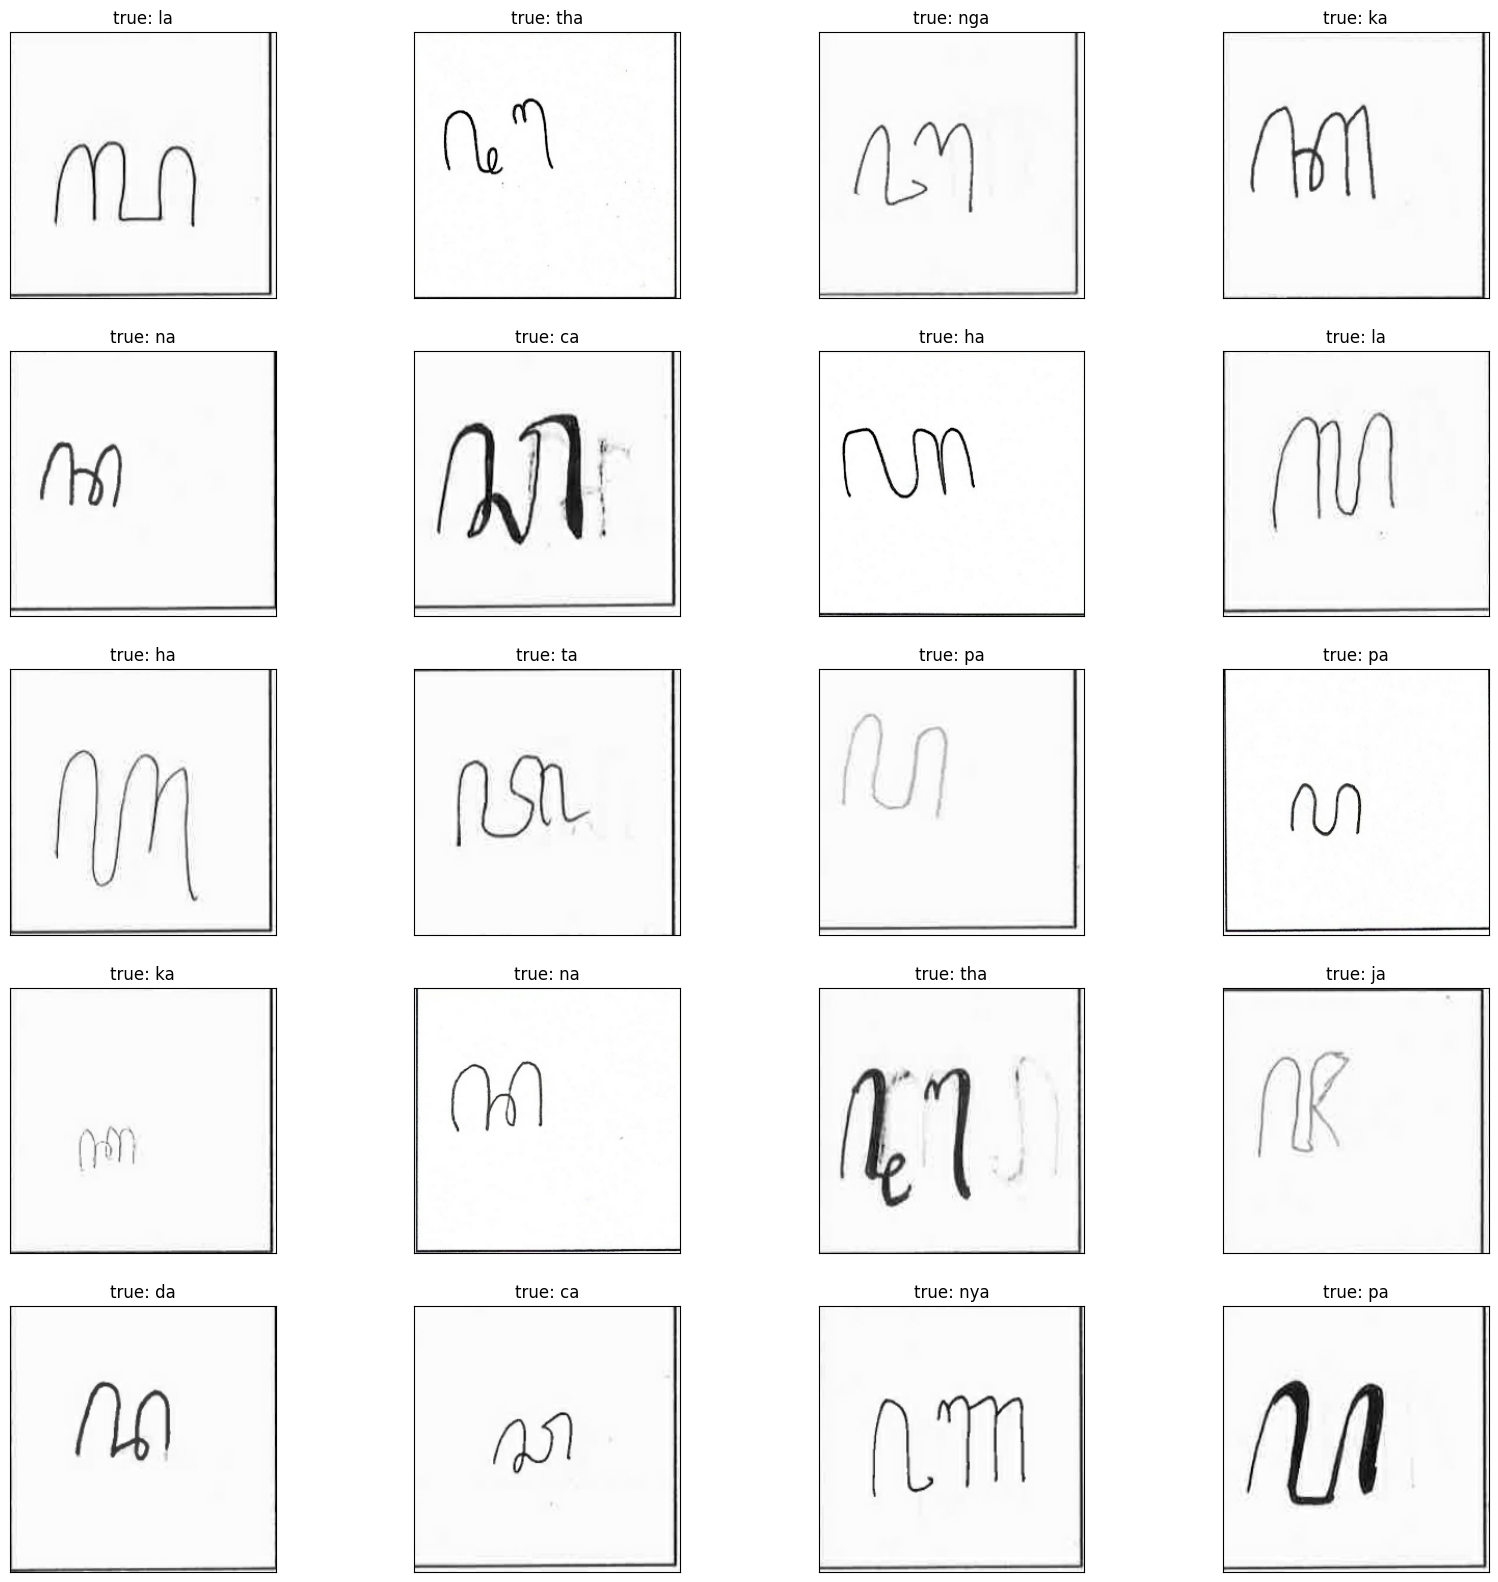

In [17]:
plot_images(real_test_ds)

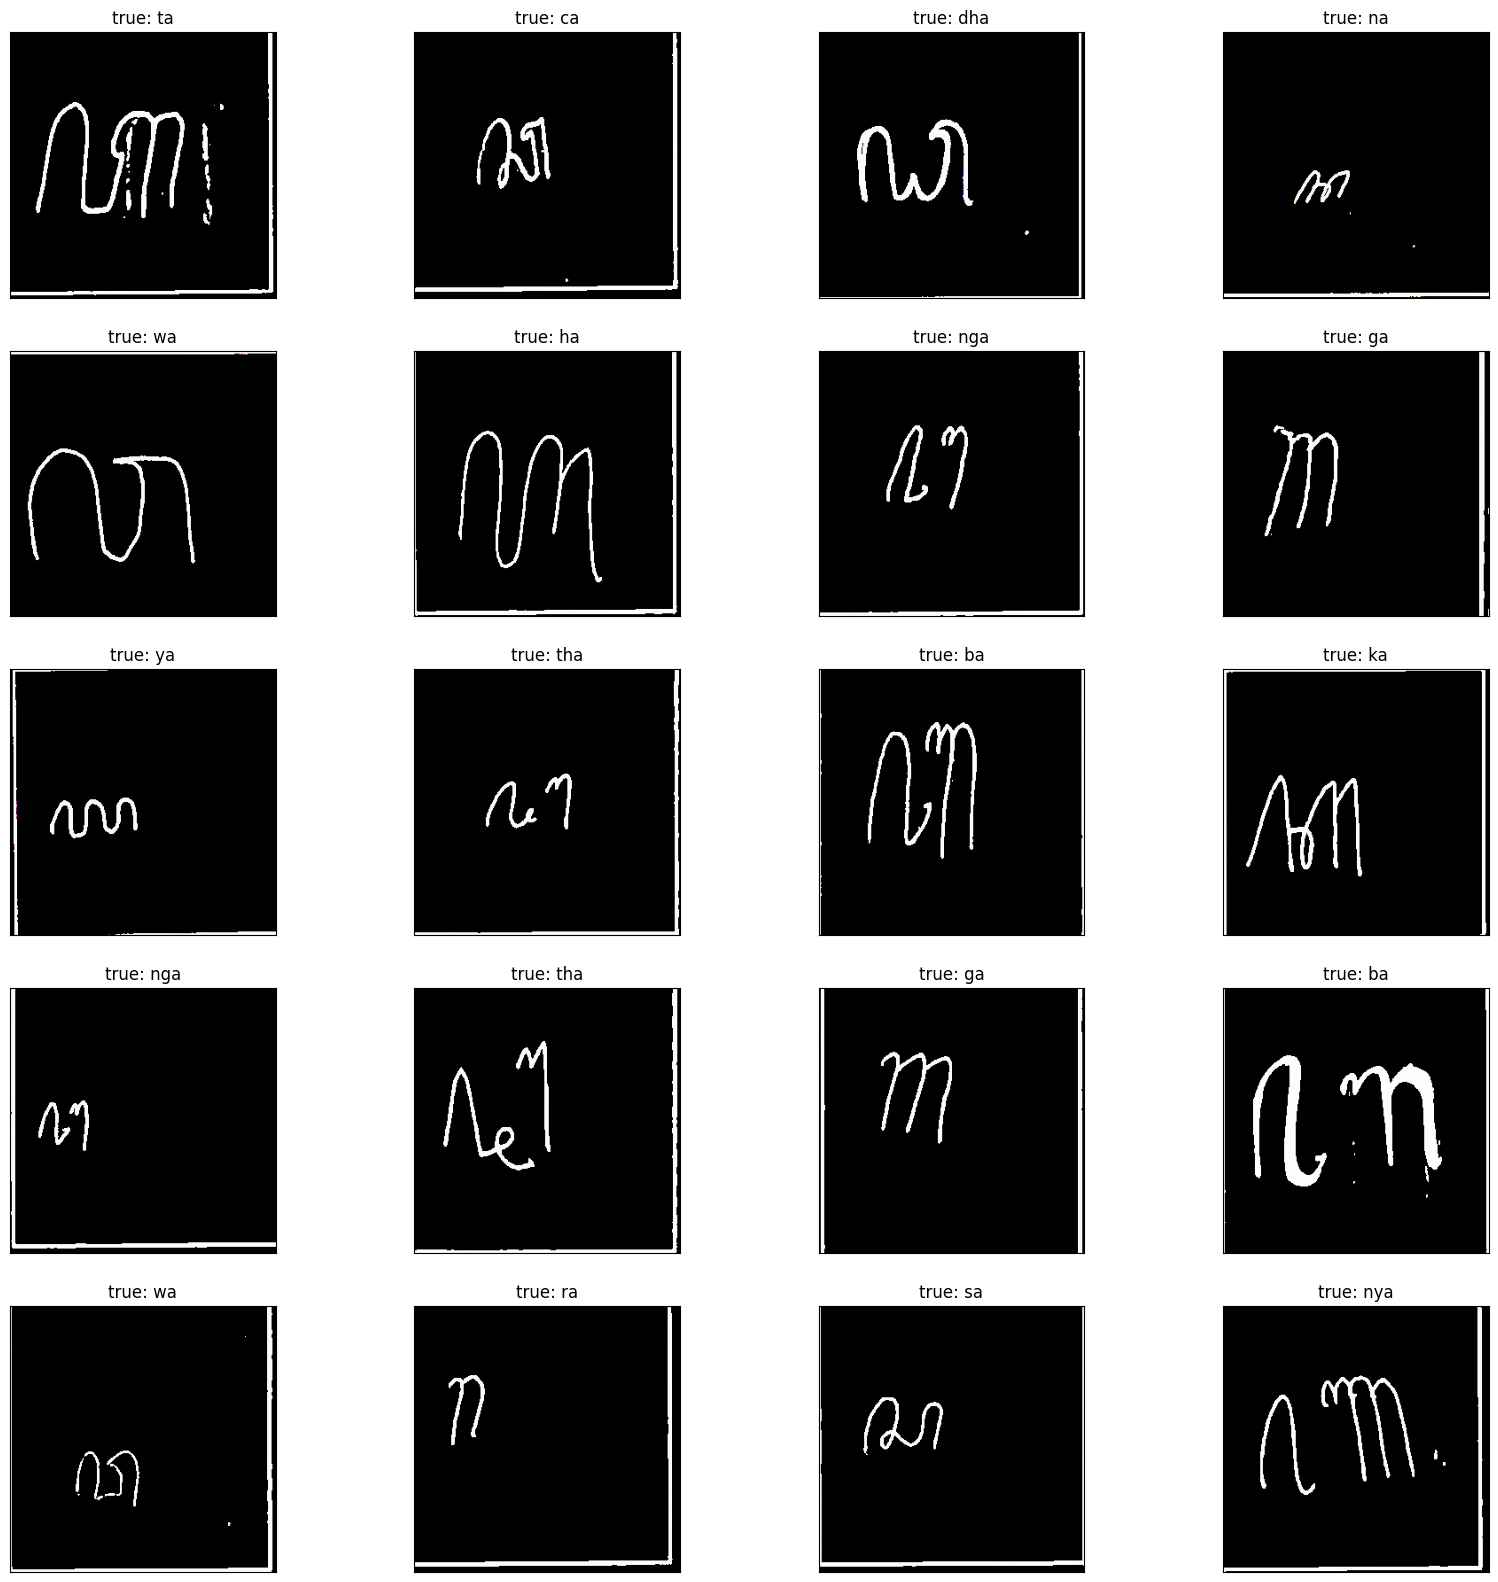

In [18]:
plot_images(real_test_ds_mapped)

In [19]:
results = pd.DataFrame(columns=['model_id', 'loss', 'accuracy'])

for id, model in loaded_models.items():
   
   print(f'START predicting with model {id} ...')
   
#    y_pred = []  # store predicted labels
#    y_true = []  # store true labels

#    # iterate over the dataset
#    for image_batch, label_batch in real_test_ds_mapped:   # use dataset.unbatch() with repeat
#       # append true labels
#       y_true.append(label_batch)
#       # compute predictions
#       preds = model.predict(image_batch, verbose=0)
#       # append predicted labels
#       y_pred.append(np.argmax(preds, axis = - 1))

#    # convert the true and predicted labels into tensors
#    correct_labels = tf.concat([item for item in y_true], axis = 0)
#    predicted_labels = tf.concat([item for item in y_pred], axis = 0)

#    print(f'==== CONFUSION MATRIX FOR MODEL {id} ====')
#    plot_confusion_m(correct_labels, predicted_labels, class_names, figsize=(8,8))
   
   loss, acc = model.evaluate(real_test_ds_mapped)
   print("Loss    : {:.4}".format(loss))
   print("Accuracy: {:.4}%".format(acc*100))
   
   result_df = pd.DataFrame({'model_id': [id], 'loss': [loss], 'accuracy': [acc]})
   results = pd.concat([results, result_df], ignore_index=True)
   
   print(f'FINISHED predicting with model {id} ... \n')

START predicting with model f_1 ...
27/27 [==============================] - 54s 2s/step - loss: 3.9144 - accuracy: 0.0933
Loss    : 3.914
Accuracy: 9.335%
FINISHED predicting with model f_1 ... 

START predicting with model f_2 ...
27/27 [==============================] - 47s 2s/step - loss: 4.1053 - accuracy: 0.0980
Loss    : 4.105
Accuracy: 9.802%
FINISHED predicting with model f_2 ... 

START predicting with model f_3 ...
27/27 [==============================] - 47s 2s/step - loss: 3.7626 - accuracy: 0.0968
Loss    : 3.763
Accuracy: 9.685%
FINISHED predicting with model f_3 ... 

START predicting with model f_4 ...
27/27 [==============================] - 48s 2s/step - loss: 0.2915 - accuracy: 0.9148
Loss    : 0.2915
Accuracy: 91.48%
FINISHED predicting with model f_4 ... 

START predicting with model f_5 ...
27/27 [==============================] - 52s 2s/step - loss: 1.3158 - accuracy: 0.6313
Loss    : 1.316
Accuracy: 63.13%
FINISHED predicting with model f_5 ... 

START predicti

# Check Errors

In [20]:
# for id, model in loaded_models.items():
#     print(f'==== MODEL {id} ====')
#     plot_images(real_test_ds_mapped, model=model, check=True, figsize=(20, 20), verbose=0)
#     print(f'==== END MODEL {id} ====\n\n')

# Export Results

In [21]:
results

,model_id,loss,accuracy
0,f_1,3.914422,0.093349
1,f_2,4.105284,0.098016
2,f_3,3.762611,0.096849
3,f_4,0.291480,0.914819
4,f_5,1.315829,0.631272
5,f_6,0.561660,0.875146
6,f_7,1.399575,0.605601
7,f_8,1.080150,0.708285
8,f_9,1.732752,0.534422
9,f_10,4.568145,0.151692


In [22]:
results_sorted = results.sort_values(by=['accuracy'], ascending=[False])
results_sorted

,model_id,loss,accuracy
3,f_4,0.291480,0.914819
5,f_6,0.561660,0.875146
12,f_13,0.519950,0.844807
22,f_23,0.614723,0.844807
16,f_17,1.343356,0.810969
17,f_18,0.932480,0.777130
13,f_14,0.817563,0.761960
7,f_8,1.080150,0.708285
15,f_16,1.217993,0.676779
26,f_27,1.156236,0.673279


In [23]:
results.to_csv('./top3_freezes_models_result.csv', index=False)

# Showcase

Single testing Model f_4 ...
==== MODEL f_4 ====


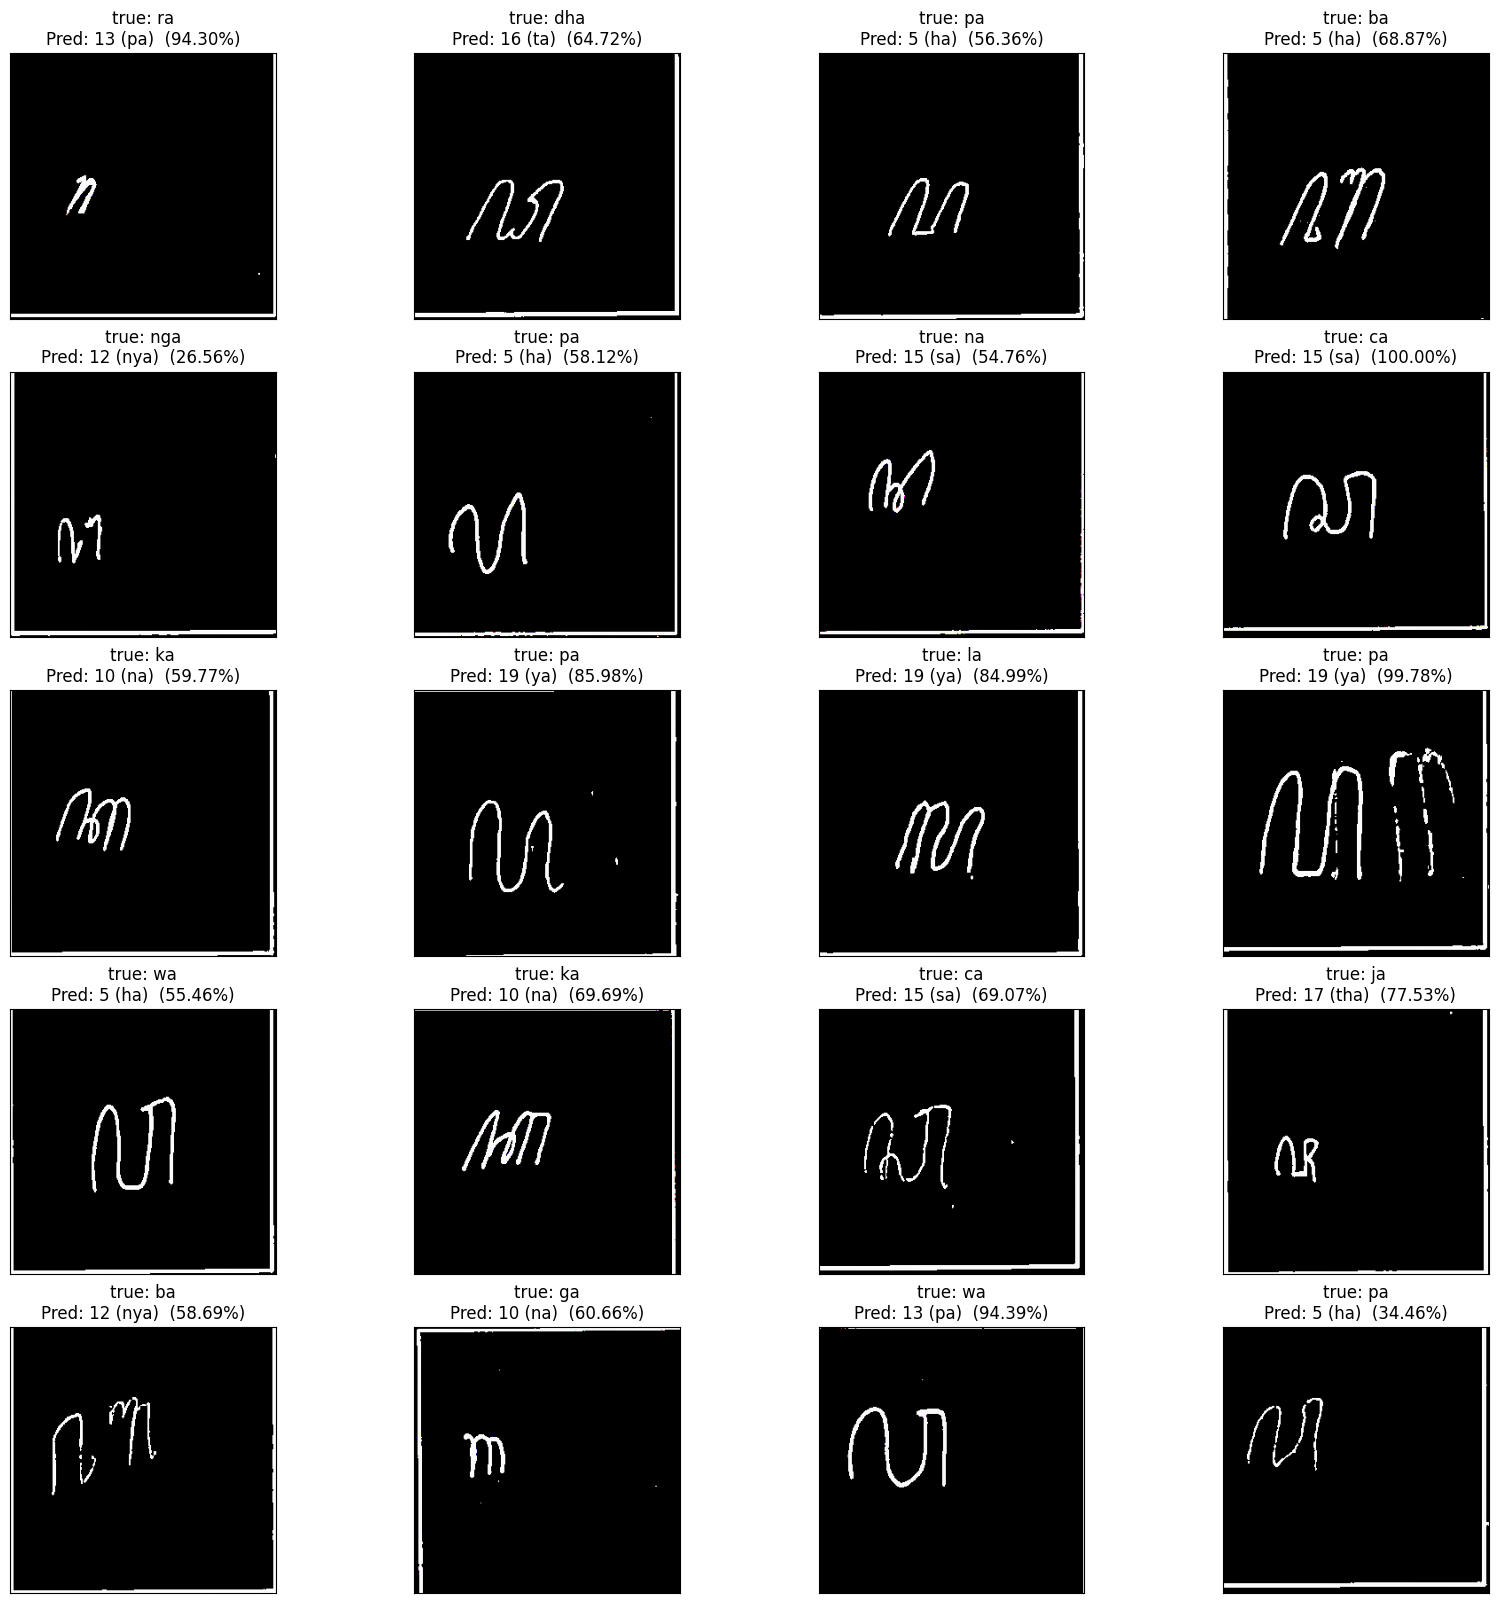

==== END MODEL f_4 ====




In [25]:
model_id = 'f_4'

print(f'Single testing Model {model_id} ...')
print(f'==== MODEL {model_id} ====')
plot_images(real_test_ds_mapped, model=loaded_models[model_id], check=True, figsize=(20, 20), verbose=0)
print(f'==== END MODEL {model_id} ====\n\n')